In [85]:
import pandas as pd
import pickle
import numpy as np

#Change monkey name here
monkey_name = 'nana'

if monkey_name == 'nana':
    file_path = 'Features_nana'
else:
    file_path = 'Features_thina'
    
with open(file_path, 'rb') as f:
    df_features,start_move,stop_turn = pickle.load(f)

In [86]:
def window_and_normalize_trial(trial, right_window=500, left_window=100):
    """
    Process and window a single trial.
    """
    signal_go = trial.iloc[0]['go_milisecond']

    # Determine the window around the go signal
    window_start = signal_go - left_window
    window_end = signal_go + right_window
    # Filter the trial to the specified window
    windowed_trial = trial[(trial['time_milisecond'] >= window_start) & (trial['time_milisecond'] <= window_end)].copy()
    new_start_time = windowed_trial.iloc[0]['time_milisecond']

    # Adjust times to start from zero within the window
    windowed_trial['adjusted_time'] = windowed_trial['time_milisecond'] - new_start_time

    # Normalize the adjusted times
    max_adjusted_time = windowed_trial['adjusted_time'].max()
    windowed_trial['normalized_time'] = windowed_trial['adjusted_time'] / max_adjusted_time

    # Use precomputed movement start and end times from the previous processing
    start_movement_time = trial['start_movement_miliseconds'].iloc[0] - new_start_time
    windowed_trial['adjusted_start_movement'] = start_movement_time
    windowed_trial['normalized_start_movement'] = start_movement_time / max_adjusted_time

    if not np.isnan(trial['updTime'].iloc[0]): #Turn & Update
        stop_turn_time = trial['stop_turn_miliseconds'].iloc[0] - new_start_time
        windowed_trial['adjusted_stop_turn'] = stop_turn_time
        windowed_trial['normalized_stop_turn'] = stop_turn_time / max_adjusted_time

    return windowed_trial

def window_trials(processed_df, right_window=500, left_window=100):
    """
    Adjust times for each trial in the processed DataFrame.
    """
    # Apply the function to all trials in the dataframe
    windowed_trials = []
    for trial_id in processed_df['id'].unique():
        trial = processed_df[processed_df['id'] == trial_id]
        windowed_trial = window_and_normalize_trial(trial, right_window, left_window)
        windowed_trials.append(windowed_trial)
    return pd.concat(windowed_trials, ignore_index=True)

df_windowed = window_trials(df_features)
df_windowed = df_windowed.reset_index(drop=True)

In [88]:
def compute_velocity_threshold_onset(df, threshold_percent):
    results = []
    
    for trial_id in df['id'].unique():
        trial_data = df[df['id'] == trial_id].copy()
        peak_velocity = trial_data['velocity'].max()
        velocity_threshold = threshold_percent * peak_velocity
        crossing_indices = trial_data[trial_data['velocity'] >= velocity_threshold].index
        
        if len(crossing_indices) > 0:
            first_crossing_idx = crossing_indices[0]
            detected_onset_time = trial_data.loc[first_crossing_idx, 'adjusted_time']
        else:
            detected_onset_time = np.nan
        
        # Get ground truth (manual annotation)
        ground_truth_onset = trial_data['adjusted_start_movement'].iloc[0]
        is_update = not np.isnan(trial_data['updTime'].iloc[0])
        # Calculate error
        if not np.isnan(detected_onset_time) and not np.isnan(ground_truth_onset):
            onset_error = detected_onset_time - ground_truth_onset
        else:
            onset_error = np.nan
        
        results.append({
            'trial_id': trial_id,
            'update': is_update,
            'peak_velocity': peak_velocity,
            'velocity_threshold': velocity_threshold,
            'detected_onset_time': detected_onset_time,
            'ground_truth_onset': ground_truth_onset,
            'onset_error_ms': onset_error,
            'absolute_error_ms': abs(onset_error) if not np.isnan(onset_error) else np.nan
})
    
    results_df = pd.DataFrame(results)
    return results_df

print("Monkey Name:", monkey_name)
threshs = [0.05, 0.10, 0.15]
for thresh in threshs:
    results = compute_velocity_threshold_onset(df_windowed, threshold_percent=thresh)
    total_mae = results['absolute_error_ms'].mean()
    total_std = results['absolute_error_ms'].std()
    total_median = results['absolute_error_ms'].median()
    # View summary statistics
    print("\n==============================")
    print("Threshold:", thresh)
    print("Movement Onset Detection Results:")
    print(f"Mean absolute error: {total_mae:.2f} ms")
    print(f"Std absolute error: {total_std:.2f} ms")
    print(f"Median absolute error: {total_median:.2f} ms")

Monkey Name: nana

Threshold: 0.05
Movement Onset Detection Results:
Mean absolute error: 64.33 ms
Std absolute error: 110.37 ms
Median absolute error: 24.97 ms

Threshold: 0.1
Movement Onset Detection Results:
Mean absolute error: 34.14 ms
Std absolute error: 80.53 ms
Median absolute error: 16.61 ms

Threshold: 0.15
Movement Onset Detection Results:
Mean absolute error: 18.98 ms
Std absolute error: 64.11 ms
Median absolute error: 8.30 ms


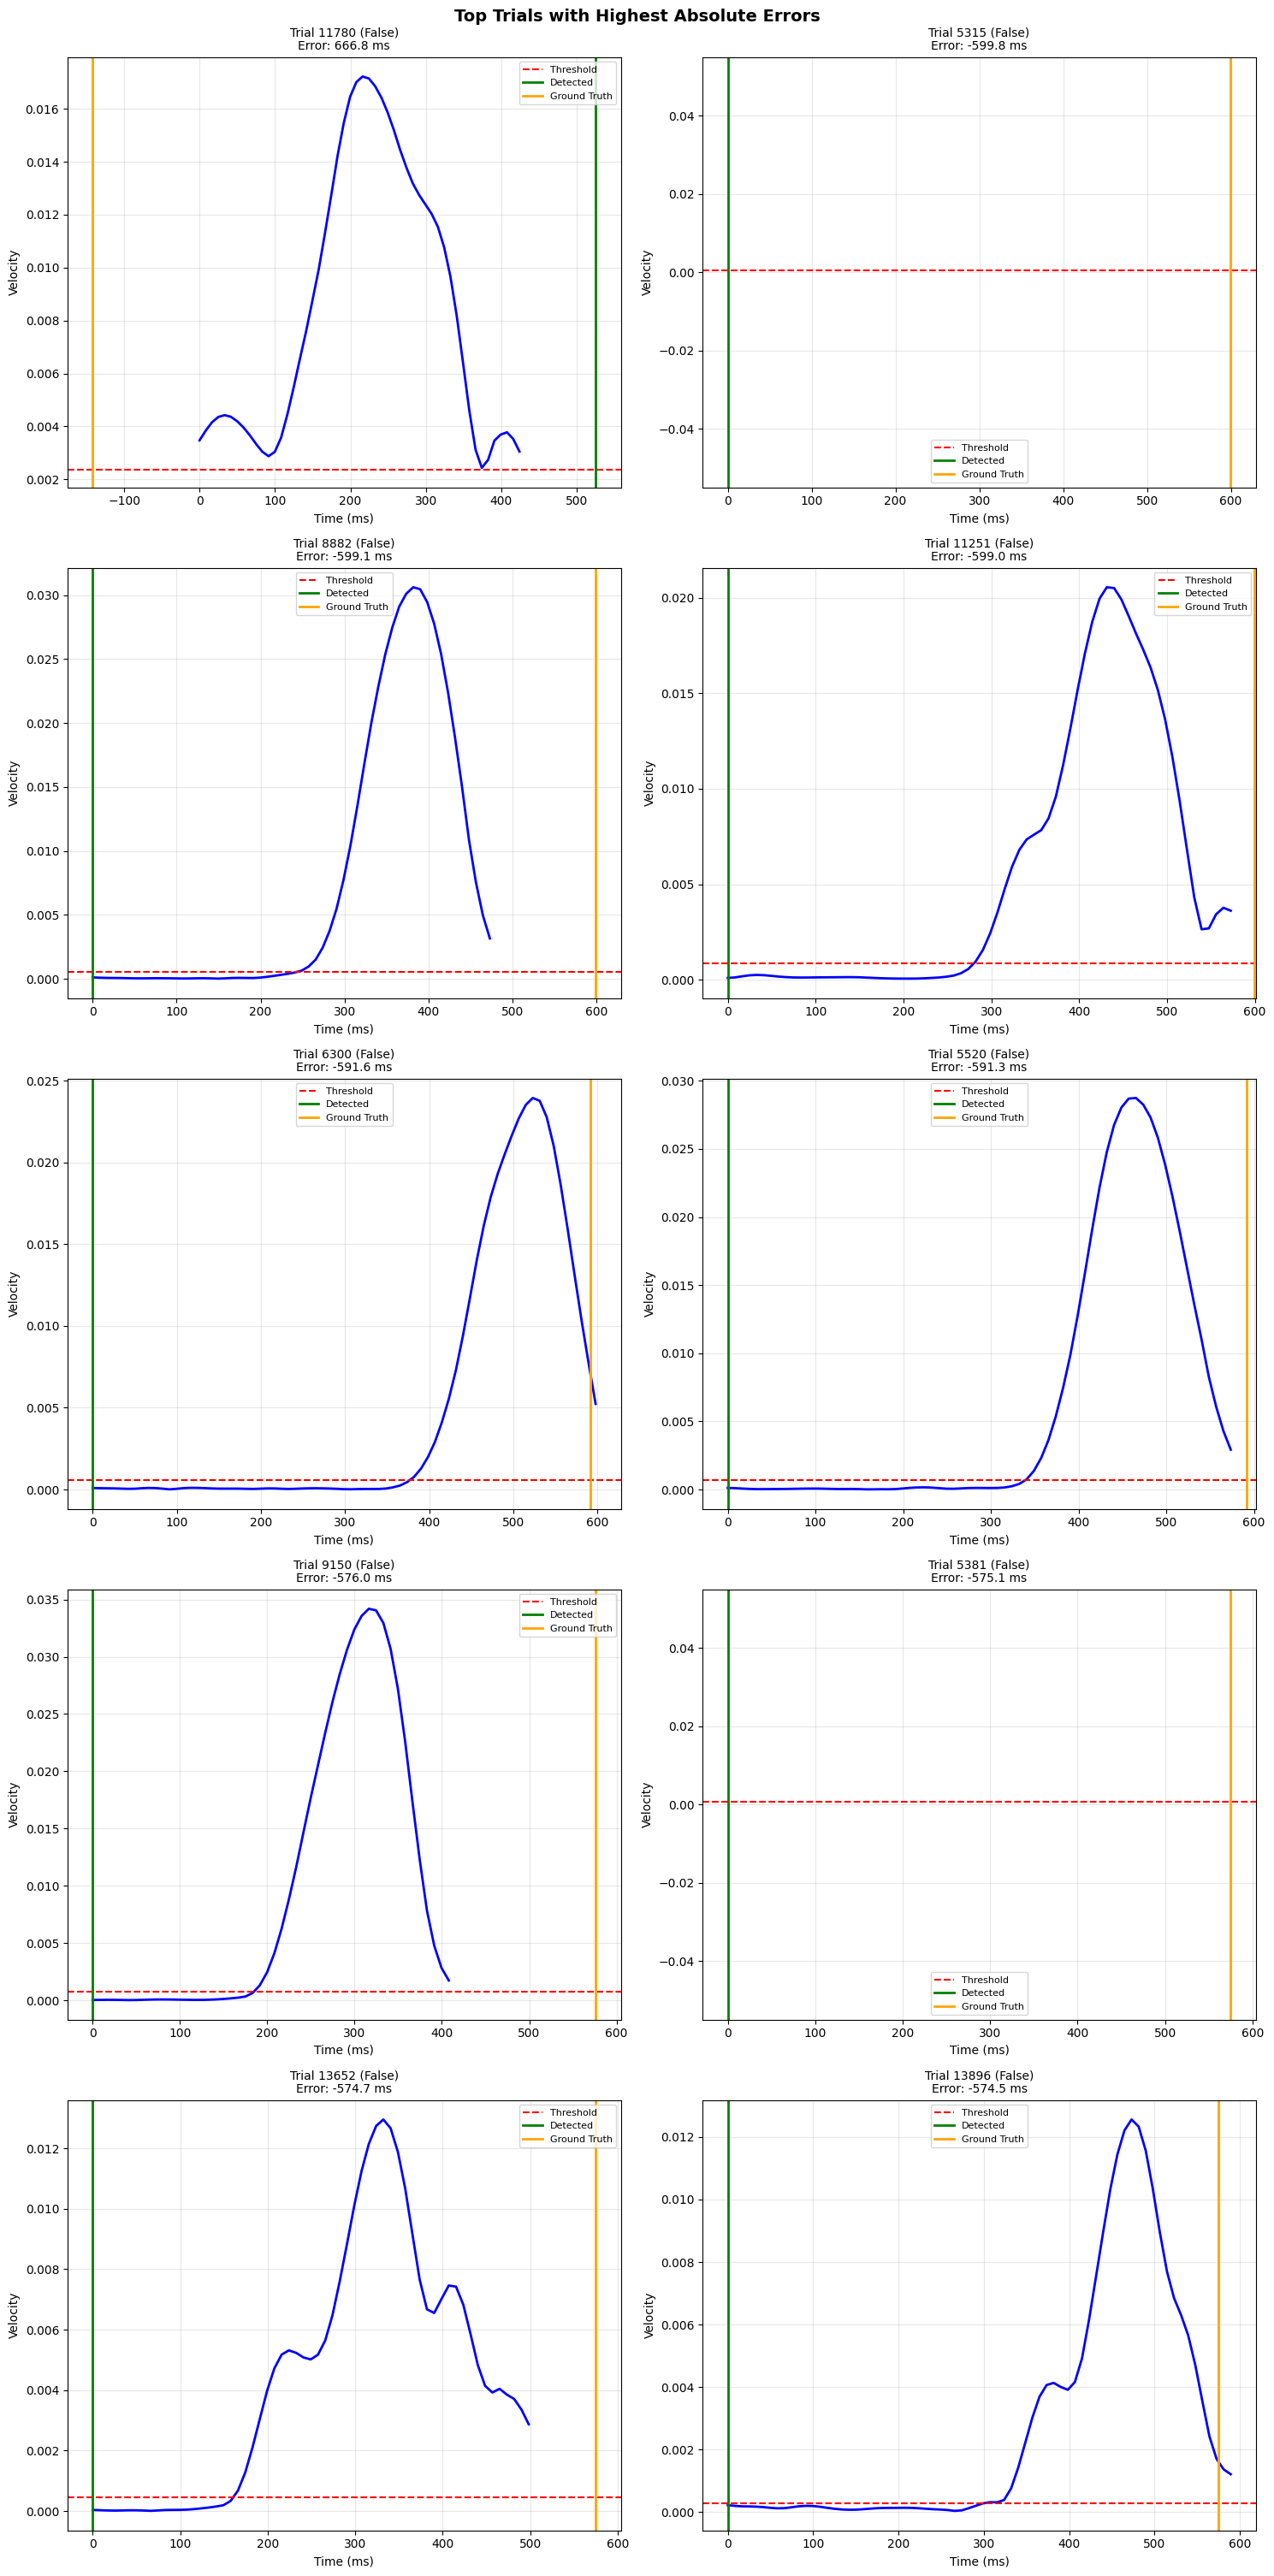

In [87]:
import matplotlib.pyplot as plt
# Plot highest error trials
def plot_highest_error_trials(df, results_df, n_trials=10):
    """
    Plot the trials with highest absolute errors.
    """
    top_errors = results_df.nlargest(n_trials, 'absolute_error_ms')
    fig, axes = plt.subplots(5, 2, figsize=(15, 30))
    axes = axes.flatten()
    
    for idx, (_, trial_results) in enumerate(top_errors.iterrows()):
        trial_id = trial_results['trial_id']
        trial_data = df[df['id'] == trial_id].sort_values('adjusted_time')
        
        ax = axes[idx]
        ax.plot(trial_data['adjusted_time'], trial_data['velocity'], 'b-', linewidth=2)
        ax.axhline(y=trial_results['velocity_threshold'], color='r', linestyle='--', 
                   linewidth=1.5, label='Threshold')
        ax.axvline(x=trial_results['detected_onset_time'], color='g', linestyle='-', 
                   linewidth=2, label='Detected')
        ax.axvline(x=trial_results['ground_truth_onset'], color='orange', linestyle='-', 
                   linewidth=2, label='Ground Truth')
        
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Velocity')
        ax.set_title(f'Trial {trial_id} ({trial_results["update"]})\n'
                    f'Error: {trial_results["onset_error_ms"]:.1f} ms', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Top Trials with Highest Absolute Errors', y=1.002, fontsize=14, fontweight='bold')
    plt.show()

# Plot highest error trials
plot_highest_error_trials(df_windowed, results, n_trials=10)